In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import copy
from boss.bo.bo_main import BOMain
from boss.settings import Settings

In [2]:
LEGEND_FONTSIZE = 16
PLOT_DICT = {'0': {'c': 'k', 'label': 'High Fidelity'},
             '1': {'c': 'r', 'label': 'Low Fidelity'}}
COLORS = {'0': 'k', '1': 'r'}

In [41]:
def high_fidelity(x):
    return (6*x - 2)**2 * np.sin(12*x - 4) 

def low_fidelity(x):
    return 0.6*high_fidelity(x) + 2*(x - 1)

In [54]:
base_rate = 2/15**2
W_prior='gaussian'
W_mean = 0.9 * np.sqrt(2 / base_rate)
W_std = 0.5 / np.sqrt(base_rate)

bo = BOMain(
    [high_fidelity, low_fidelity], 
    bounds=np.array([[0, 1]]),
    yrange=np.array([-10, 20]),
    num_tasks=2,
    kernel=['rbf'],
    initpts=np.array([2, 12]),
    iterpts=1,
    seed=123,
    #W_prior=W_prior,
    #W_priorpar=[W_mean, W_std],
    maxcost=10,
    acqcost=[1, 0.1],
    outfile='./mt_forrester.out',
    rstfile='./mt_forrester.rst'
)

res = bo.run()

In [55]:
x = np.linspace(0, 1, 100)[:, None]

samples_LF = X_LF, Y_LF = res.bo.model.get_X(index=1), res.bo.model.get_Y(index=1)
samples_HF = X_HF, Y_HF = res.bo.model.get_X(index=0), res.bo.model.get_Y(index=0)
mean_LF, var_LF = res.bo.model.predict(x, index=1)
mean_HF, var_HF = res.bo.model.predict(x, index=0)


In [56]:
x_min_pred, y_min_pred = res.convergence[-1, -3], res.convergence[-1, -2]

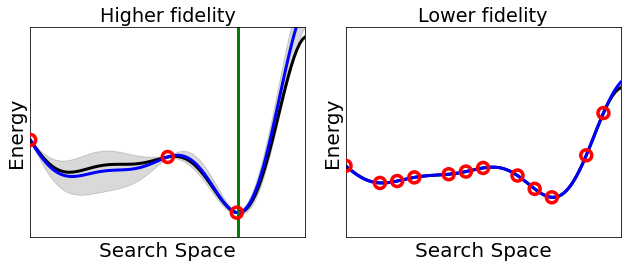

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

for ax_idx, fidelity, samples, mean, var in zip([0,1], [high_fidelity, low_fidelity], [samples_HF, samples_LF],
                                                 [mean_HF, mean_LF], [var_HF, var_LF]):
    axs[ax_idx].plot(x, fidelity(x), c='k', linewidth=3)
    axs[ax_idx].scatter(samples[0], samples[1], linewidth=3.5, s=120, zorder=3, facecolors='none', edgecolors='r')
    axs[ax_idx].plot(x, mean, c='b', lw=3)
    mean, var = mean.squeeze(), var.squeeze()
    axs[ax_idx].fill_between(x.squeeze(), (mean - 2 * np.sqrt(var)), 
                                          (mean + 2 * np.sqrt(var)), 
                                          color='k', alpha=.15)
    axs[ax_idx].set_yticks([])
    axs[ax_idx].set_xticks([])
    axs[ax_idx].set_xlabel('Search Space', fontsize=20)
    axs[ax_idx].set_ylabel('Energy', fontsize=20)

axs[0].axvline(x_min_pred, c='green', lw=3)
axs[0].set_title("Higher fidelity")
axs[1].set_title("Lower fidelity")
axs[1].set_xlabel('Search Space', fontsize=20)

for ax in axs: 
    ax.set_xlim(0, 1)
    ax.set_ylim(-9,17)
fig.tight_layout()
plt.savefig('multi-task-toymodel.pdf', dpi=300)